# Import Library

In [430]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from tqdm import tqdm
from copy import deepcopy

# Classes and Function

In [431]:
class Point: 
    def __init__(self, id, x, y, partition):
        self.id = id
        self.partition = partition
        self.x = x
        self.y = y 

    def get_pos(self):
        return self.x, self.y

In [441]:
class Graph: 
    def __init__(self, points = {}, weight = np.array([[]])): 
        self.points = points
        self.weight = weight
        self.all_weight = weight

    def get_points(self):
        return self.points        
        
    def get_partition_points(self, partition):
        temp = {}
        for i in self.points: 
            if self.points[i].get('partition') == partition: 
                temp[i] = self.points[i]
                
        return temp

    def get_partition(self):
        partition_result = np.array([])
        for i in self.points:
            partition_result = np.append(partition_result, self.points[i].get('partition'))

        return partition_result
        
    def get_unique_partition(self):
        return list(dict.fromkeys(self.get_partition()))
    
    def get_points_coords(self): 
        points_x = np.array([])
        points_y = np.array([])

        for i in self.points:
            points_x = np.append(points_x, self.points[i].get('x'))
            points_y = np.append(points_y, self.points[i].get('y'))

        return points_x, points_y
    
    def get_partition_points_coords(self, partition):
        points_x = np.array([])
        points_y = np.array([])

        for i in self.get_partition_points(partition):
            points_x = np.append(points_x, self.points[i].get('x'))
            points_y = np.append(points_y, self.points[i].get('y'))

        return points_x, points_y

    def get_weight(self):
        return self.weight

    def get_spread(self):
        points_x, points_y = self.get_points_coords()
        return max(max(points_x) - min(points_y), max(points_y) - min(points_y))

    def get_partition_spread(self, partition):
        points_x, points_y = self.get_partition_points_coords(partition)
        if(len(points_x) == 0):
            return 0
        return max(max(points_x) - min(points_y), max(points_y) - min(points_y))

    def get_edge_cut(self):
        edge_cut = {}
        size = len(self.points)
        for i in range(size):
            for j in range(i, size):
                if(weight[j, i] != 0 and self.points[i].get('partition') != self.points[j].get('partition')):
                    edge_cut[(j, i)] = weight[j, i]
        return edge_cut

    def get_partition_size(self, partition):
        points_x, _ = self.get_partition_points_coords(partition)
        return len(points_x)

    def is_connected(self):
        if(self.weight.size == 0): 
            return False
            
        num_vertices = len(self.points)

        def dfs(vertex, visited):
            visited[vertex] = True
            for neighbor in range(num_vertices):
                if self.weight[vertex, neighbor] != 0 and not visited[neighbor]:
                    dfs(neighbor, visited)

        visited = [False] * num_vertices

        dfs(0, visited)

        return all(visited) 

    def is_partition_connected(self, partition):
        if(self.weight.size == 0): 
            return False
        
        num_vertices = len(self.get_partition_points(partition))

        def dfs(vertex, visited, idx=-1):
            visited[idx] = True
            for i, neighbor in enumerate(self.get_partition_points(partition)):
                if self.weight[vertex, neighbor] != 0 and not visited[i]:
                    dfs(neighbor, visited, i)

        visited = [False] * num_vertices
        dfs([v for v in self.get_partition_points(partition)][0], visited, 0)

        return all(visited)          
    
    def is_all_partition_connected(self): 
        connected = [True] * len(self.get_unique_partition())
        for i in self.get_unique_partition():
            connected[int(i) - 1] = self.is_partition_connected(i)

        return all(connected)
        
    def calculate_weight(self, min_s, max_s, debug=False):
        iteration = 0
        points_x, points_y = self.get_points_coords()
        size = len(points_x)
        temp = np.zeros([size, size])
        for i in range(size):
            for j in range(size):
                temp[i, j] = np.sqrt(np.abs(points_x[i] - points_x[j]) ** 2 + np.abs(points_y[i] - points_y[j]) ** 2)
        
        self.all_weight = np.copy(temp)
        self.weight = np.zeros([size, size])
        while(not self.is_connected()):
            iteration += 1
            if(min_s != 0 and max_s != 0):
                new_weight = np.zeros([size, size])
                
                for j in range(size):
                    n_edge_rand = np.random.randint(min_s, max_s)
                    idx = np.argpartition(self.all_weight[j, :], n_edge_rand)
                    for k in idx[1:n_edge_rand + 1]:
                        new_weight[j, k] = self.all_weight[j, k]
                    new_weight[:, j] = new_weight[j, :]
                    
            self.weight = np.copy(new_weight)

            if(iteration % 100 == 0):
                if(min_s < max_s - 1):
                    min_s += 1
                else:
                    max_s += 1
        if(debug):
            print('Iterations: ', iteration, 'Min Side:', min_s, 'Max Side:', max_s)
        return self.weight

    def update_partition(self, id, partition):
        self.points[id]['partition'] = partition

    def add_point(self, point): 
        self.points[point.id] = {'x': point.x, 'y': point.y, 'partition': point.partition}

    def remove_point(self, id):
        try:
            self.points.pop(id)
        except:
            print('point not in partition')

    def mutate_graph(self, debug=False):
        G = nx.Graph(self.get_weight())
        while True:
            random = np.random.randint(0, len(weight))
            neighbor = [n for n in G.neighbors(random)]
            random_neighbor = np.random.randint(0, len(neighbor))

            if(self.points[neighbor[random_neighbor]].get("partition") != self.points[random].get("partition")):
                prev_partition = self.points[random].get("partition")
                self.update_partition(random, self.points[(neighbor[random_neighbor])].get("partition"))
                if(len(self.get_partition_points(prev_partition)) > 0):
                    if(self.is_partition_connected(prev_partition)):
                        new_partition = self.points[(neighbor[random_neighbor])].get("partition")
                        if(debug):
                            print(f"Mutate Nodes {random} from {prev_partition} to {new_partition}")
                        self.update_partition(random, new_partition)
                        break
                else: 
                    self.update_partition(random, prev_partition)

In [442]:
    def generate_rand_points(graph, n, interval): 
        temp = np.random.rand(2, n) * interval[0] + interval[1]
        for i in range(n):
            graph.add_point(Point(i, temp[0, i], temp[1, i], -1))
        return graph

In [443]:
def crossover(a, b, n_partition, iter=0, debug=False):
    a_target = np.random.randint(1, n_partition + 1)
    b_target = np.random.randint(1, n_partition + 1)

    if(debug):
        print("Crossover Target")
        print(f"Population A : Partition {a_target}")
        print(f"Population B : Partition {b_target}")

    temp_a_cross = {}
    temp_b_cross = {}

    population_a_temp = deepcopy(a)
    population_b_temp = deepcopy(b)

    population_a_res = deepcopy(a)
    population_b_res = deepcopy(b)

    for i in population_a_temp.get_partition_points(a_target):
        partition = population_b_res.get_points().get(i).get('partition')
        val = temp_a_cross.get(partition, 0)
        temp_a_cross[partition] = val + 1

    for i in population_b_res.get_partition_points(max(temp_a_cross, key=temp_a_cross.get)):
        population_b_res.update_partition(i, 0)
        
    for i in population_a_temp.get_partition_points(a_target):
        population_b_res.update_partition(i, max(temp_a_cross, key=temp_a_cross.get))

    for i in population_b_temp.get_partition_points(b_target):
        partition = population_a_res.get_points().get(i).get('partition')
        val = temp_b_cross.get(partition, 0)
        temp_b_cross[partition] = val + 1

    for i in population_a_res.get_partition_points(max(temp_b_cross, key=temp_b_cross.get)):
        population_a_res.update_partition(i, 0)
        
    for i in population_b_temp.get_partition_points(b_target):
        population_a_res.update_partition(i, max(temp_a_cross, key=temp_a_cross.get))

    G = nx.Graph(np.array(population_a_res.weight))

    a_check = False 
    b_check = False 

    while len(population_a_res.get_partition_points(0)) > 0 or len(population_b_res.get_partition_points(0)) > 0:
        population_a_excess = population_a_res.get_partition_points(0)
        population_b_excess = population_b_res.get_partition_points(0)
        
        count_null_population_a = 0
        for i in population_a_excess:
            partition_id, min_partition = -1, -1
            for j in [n for n in G.neighbors(i)]:
                partition = population_a_res.get_points().get(j).get('partition')
                if(min_partition == -1 and (partition != 0 and partition != max(temp_a_cross, key=temp_a_cross.get))):
                    partition_id, min_partition = partition, len(population_a_res.get_partition_points(partition))
                elif(min_partition > len(population_a_res.get_partition_points(partition)) and (partition != 0 and partition != max(temp_a_cross, key=temp_a_cross.get))):
                    partition_id, min_partition = partition, len(population_a_res.get_partition_points(partition))
            if(a_check):
                population_a_res.update_partition(i, max(temp_a_cross, key=temp_a_cross.get))
            elif(min_partition != -1):
                population_a_res.update_partition(i, partition_id)
            elif(min_partition == -1):
                count_null_population_a += 1

        if(count_null_population_a == len(population_a_excess)):
            a_check = True

        count_null_population_b = 0
        for i in population_b_excess:
            partition_id, min_partition = -1, -1
            for j in [n for n in G.neighbors(i)]:
                partition = population_b_res.get_points().get(j).get('partition')
                if(min_partition == -1 and (partition != 0 and partition != max(temp_b_cross, key=temp_b_cross.get))):
                    partition_id, min_partition = partition, len(population_b_res.get_partition_points(partition))
                elif(min_partition > len(population_b_res.get_partition_points(partition)) and (partition != 0 and partition != max(temp_b_cross, key=temp_b_cross.get))):
                    partition_id, min_partition = partition, len(population_b_res.get_partition_points(partition))
            if(b_check):
                population_b_res.update_partition(i, max(temp_b_cross, key=temp_b_cross.get))
            elif(min_partition != -1):
                population_b_res.update_partition(i, partition_id)
            elif(min_partition == -1):
                count_null_population_b += 1

        if(count_null_population_b == len(population_b_excess)):
            b_check = True

    if(iter >= n_partition ** 3):
        if(debug):
            print("All possibilities tried, but failed")
        return a, b

    if(len(population_a_res.get_unique_partition()) == n_partition and len(population_b_res.get_unique_partition()) == n_partition):
        if(population_a_res.is_all_partition_connected() and population_b_res.is_all_partition_connected()):
            if(debug):
                print("Success")
            return population_a_res, population_b_res
        else: 
            if(debug):
                print("Failed, retrying with other partition\n")
            return crossover(a, b, n_partition, iter + 1)
    else:
        if(debug):
            print("Failed, retrying with other partition\n")
        return crossover(a, b, n_partition, iter + 1)

In [444]:
def dominates(solution1, solution2):
    dominates_obj1 = np.all(solution1[1:] <= solution2[1:])
    better_in_at_least_one = np.any(solution1[1:] < solution2[1:])
    return dominates_obj1 and better_in_at_least_one

def non_dominated_sort(population):
    fronts = []
    num_solutions = population.shape[0]
    domination_count = np.zeros(num_solutions, dtype=int)
    dominated_solutions = {i: [] for i in range(num_solutions)}
    
    for i, solution in enumerate(population):
        for j, other_solution in enumerate(population[i + 1:], start=i + 1):
            if dominates(solution, other_solution):
                domination_count[j] += 1
                dominated_solutions[i].append(j)
            elif dominates(other_solution, solution):
                domination_count[i] += 1
                dominated_solutions[j].append(i)
    
    front = []
    for i, count in enumerate(domination_count):
        if count == 0:
            front.append(i)
    
    fronts.append(front)
    current_rank = 1
    while len(fronts[-1]) > 0:
        next_front = []
        for i in fronts[-1]:
            for j in dominated_solutions[i]:
                domination_count[j] -= 1
                if domination_count[j] == 0:
                    next_front.append(j)
        current_rank += 1
        fronts.append(next_front)
    
    return fronts

def crowding_distance(front, objectives):
    num_objectives = objectives.shape[1]
    num_solutions = len(front)
    distances = np.zeros(num_solutions)
    
    for obj_index in range(num_objectives):
        sorted_front = sorted(front, key=lambda x: objectives[x][obj_index])
        distances[0] = distances[-1] = np.inf
        
        if num_solutions > 2:
            min_obj_val = objectives[sorted_front[0]][obj_index]
            max_obj_val = objectives[sorted_front[-1]][obj_index]

            if max_obj_val == min_obj_val:
                continue
            
            for i in range(1, num_solutions - 1):
                distances[i] += (objectives[sorted_front[i+1]][obj_index] - objectives[sorted_front[i - 1]][obj_index]) / (max_obj_val - min_obj_val)
    
    return distances

In [445]:
def random_connected_partitions(graph, adjacency_matrix, num_partitions):
    G = nx.Graph(np.array(adjacency_matrix))
    G_full = nx.Graph(np.array(adjacency_matrix))

    def bfs_limit(graph, source, min_size):
        visited = set()
        queue = [source]

        while queue and len(visited) < min_size:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                queue.extend(neighbor for neighbor in graph.neighbors(node) if neighbor not in visited)

        return visited
        
    nodes = list(G.nodes())

    partition_size = len(nodes) // num_partitions // 2
    partitions = []
    current_degree = 1

    for i in range(num_partitions):
        degree = {}
        for j in G.nodes():
            temp = degree.get(G.degree(j), np.array([]))
            temp = np.append(temp, int(j))
            np.random.shuffle(temp)
            degree[G.degree(j)] = temp
            
        while True:
            if(len(degree.get(current_degree, [])) == 0):
                current_degree += 1
            else: 
                temp = degree.get(current_degree)
                np.random.shuffle(temp)

                start_node = degree.get(current_degree)[0]
                break

        partition = list(bfs_limit(G, start_node, partition_size))
        G.remove_nodes_from(partition)
        partitions.append(partition)
        
    while (len(G.nodes())):
        updated_node = []
        for i in G.nodes():
            index, min_partition = -1, -1
            for j, val in enumerate([n for n in G_full.neighbors(i)]):
                for k, val_p in enumerate(partitions): 
                    if(val in val_p and min_partition == -1):
                        index = k
                        min_partition = len(val_p)
                    elif(val in val_p and len(val_p) < min_partition):
                        index = k
                        min_partition = len(val_p)
            if(min_partition != -1):
                updated_node.append(i)
                partitions[index].append(i)
        G.remove_nodes_from(updated_node)

    partition_vector = np.zeros(len(nodes), dtype=int)
    for i, partition in enumerate(partitions):
        partition_vector[[int(j) for j in partition]] = i + 1

    for i, val in enumerate(partition_vector):
        graph.update_partition(i, val)

# Generate Graph

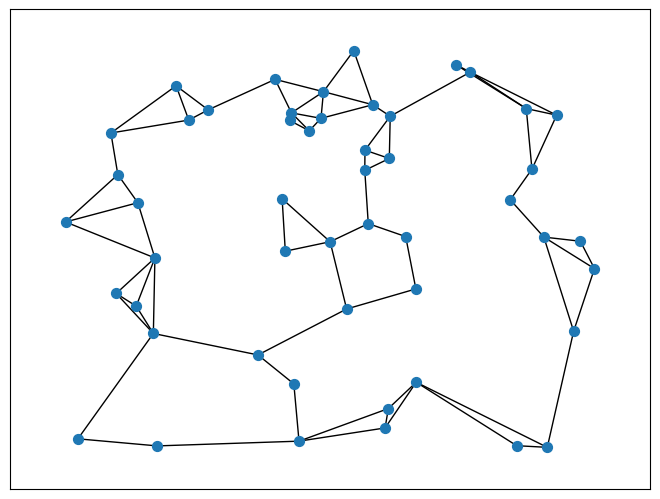

In [449]:
n_points = 50
n_partition = 5
interval = [-30, 30]

graph = generate_rand_points(Graph(), n_points, interval)
points_x, points_y = graph.get_points_coords()

weight = graph.calculate_weight(1, 2)
pos = {i: (graph.get_points()[i].get("x"), graph.get_points()[i].get("y")) for i in graph.get_points()}

G = nx.Graph(np.array(weight))
nx.draw(G, node_size=50, pos=pos)
plt.axis("on")
plt.show()

# Genetic Algorithm 

## Objective Function

In [412]:
def f1_obj(edge_cut):
    sum = 0
    for i in edge_cut: 
        sum += edge_cut.get(i, 0)
    return sum

def f2_obj(graph, n):
    sum = 0
    for i in range(n - 1):
        for j in range(i, n):
            sum += np.abs(graph.get_partition_size(i + 1) - graph.get_partition_size(j + 1)) 
    return sum

def f3_obj(graph, n):
    sum = 0
    for i in range(n):
        sum += graph.get_partition_spread(i + 1)
    return sum

## Selection 

In [413]:
n_population = 3
populations = np.array([])
partition_results = np.array([])

for i in tqdm(range(n_population)):
    new_graph = deepcopy(graph) 
    partition_result = random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)
    partition_results = np.append(partition_results, partition_result)

100%|██████████| 3/3 [00:00<00:00, 489.72it/s]


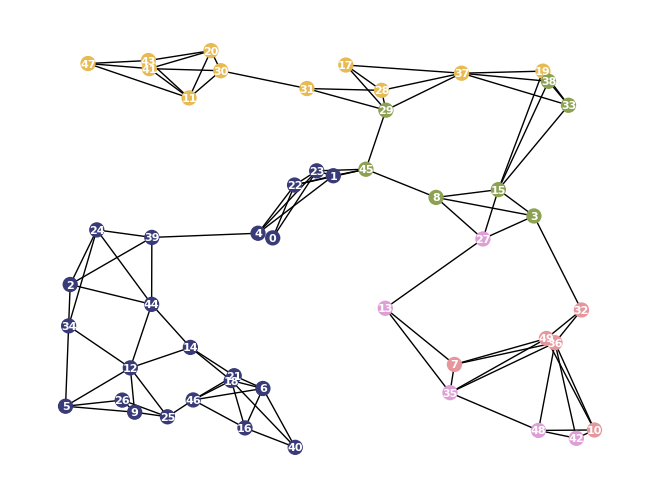

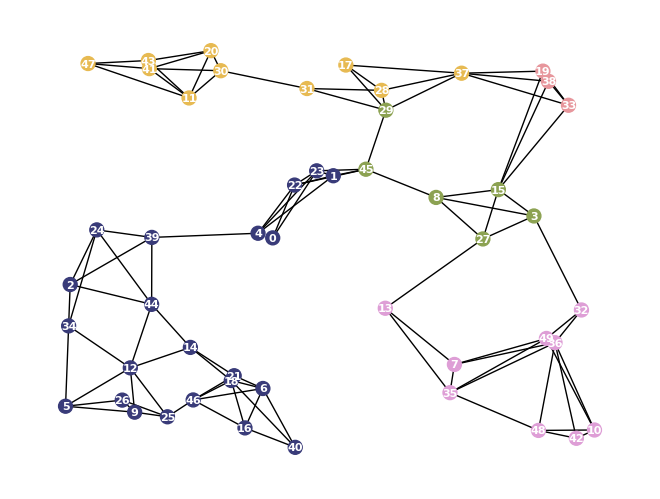

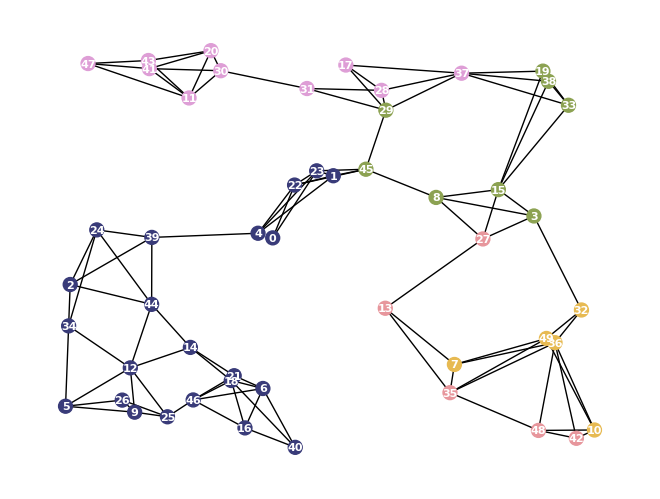

In [414]:
for population in populations:
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    # labels = {node: f'{int(partition_result[node])}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [415]:
for i, population in enumerate(populations):
    print(f"Population-{i + 1}")
    print(f"> f1 = {f1_obj(populations[i].get_edge_cut())}")
    print(f"> f2 = {f2_obj(population, n_partition)}")
    print(f"> f3 = {f3_obj(population, n_partition)}")

Population-1
> f1 = 105.11655374844874
> f2 = 80
> f3 = 89.87296899486958
Population-2
> f1 = 79.05963060498567
> f2 = 84
> f3 = 65.68209395519426
Population-3
> f1 = 97.10803466518071
> f2 = 78
> f3 = 89.87296899486958


## Mutation

Mutate Nodes 22 from 1 to 4


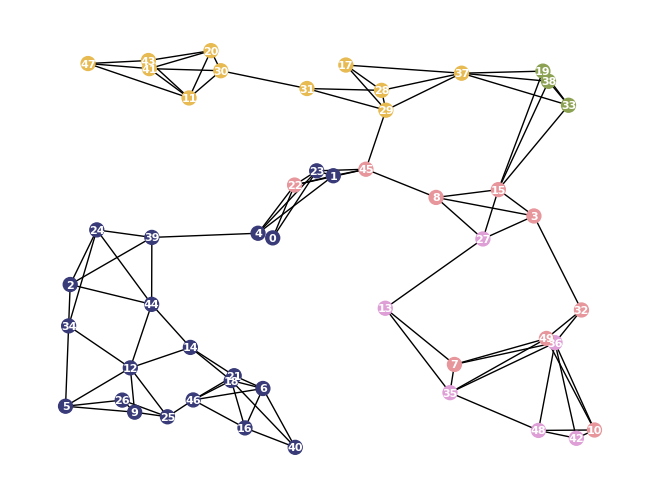

Mutate Nodes 37 from 3 to 2


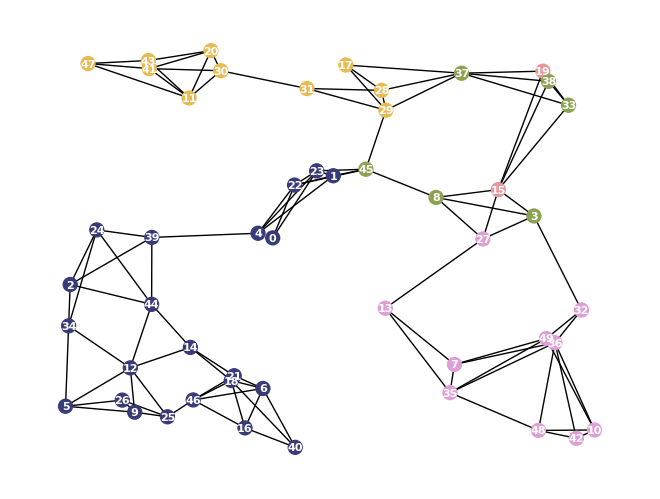

In [421]:
for population in populations[:2]:
    population.mutate_graph(debug=True)
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [417]:
for i, population in enumerate(populations):
    print(f"Population-{i + 1}")
    print(f"> f1 = {f1_obj(populations[i].get_edge_cut())}")
    print(f"> f2 = {f2_obj(population, n_partition)}")
    print(f"> f3 = {f3_obj(population, n_partition)}")

Population-1
> f1 = 100.6926635846198
> f2 = 82
> f3 = 89.87296899486958
Population-2
> f1 = 68.344790583814
> f2 = 88
> f3 = 66.56629722452521
Population-3
> f1 = 97.10803466518071
> f2 = 78
> f3 = 89.87296899486958


## Crossover

In [418]:
populations[0], populations[1] = crossover(populations[0], populations[1], 5)

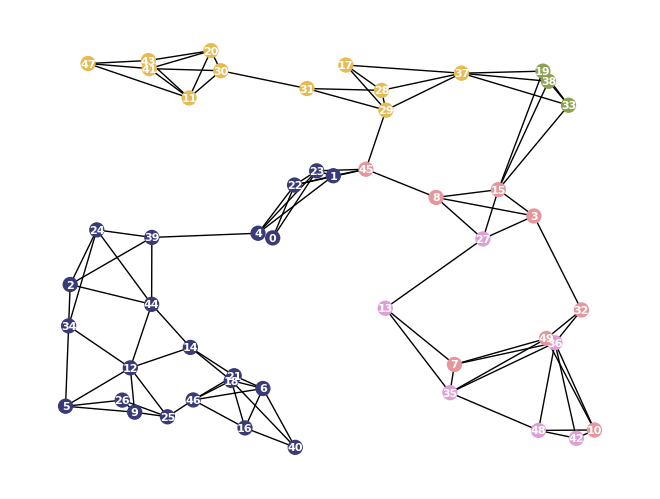

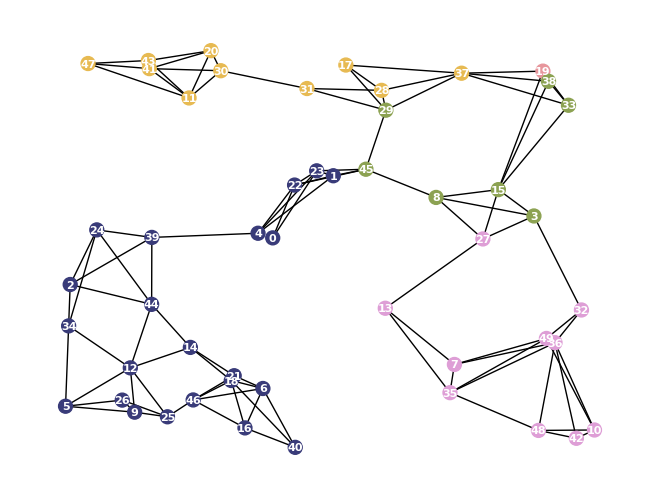

In [419]:
for population in populations[:2]:
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [420]:
for i, population in enumerate(populations):
    print(f"Population-{i + 1}")
    print(f"> f1 = {f1_obj(populations[i].get_edge_cut())}")
    print(f"> f2 = {f2_obj(population, n_partition)}")
    print(f"> f3 = {f3_obj(population, n_partition)}")

Population-1
> f1 = 99.1663454210366
> f2 = 86
> f3 = 82.75536168676484
Population-2
> f1 = 70.68116371366024
> f2 = 90
> f3 = 62.95083474258006
Population-3
> f1 = 97.10803466518071
> f2 = 78
> f3 = 89.87296899486958


# NSGA 2

## Objective Function

In [450]:
def f1_obj(edge_cut):
    sum = 0
    for i in edge_cut: 
        sum += edge_cut.get(i, 0)
    return sum

def f2_obj(graph, n):
    sum = 0
    for i in range(n - 1):
        for j in range(i, n):
            sum += np.abs(graph.get_partition_size(i + 1) - graph.get_partition_size(j + 1)) 
    return sum

def f3_obj(graph, n):
    sum = 0
    for i in range(n):
        sum += graph.get_partition_spread(i + 1)
    return sum

In [451]:
mutation_rate = 0.6
crossover_rate = 0.5
n_iteration = 2000
n_population = 50

In [452]:
populations = np.array([])
for i in tqdm(range(n_population)):
    new_graph = deepcopy(graph) 
    random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)

for i in tqdm(range(n_iteration)):
    populations_with_offspring = np.copy(populations)

    for i in range(n_population // 2):
        a = deepcopy(populations[np.random.randint(0, n_population)])
        b = deepcopy(populations[np.random.randint(0, n_population)])
        
        populations = np.append(new_graph, populations)
        if(np.random.rand() <= crossover_rate):
            a, b = crossover(a, b, n_partition)
        if(np.random.rand() <= mutation_rate):
            a.mutate_graph()
        if(np.random.rand() <= mutation_rate):
            b.mutate_graph()
        
        populations_with_offspring = np.append(populations_with_offspring, [a, b])

    f_list = np.array([])
    for i, population in enumerate(populations_with_offspring):
        f_list = np.append(f_list, [i, f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

    f_list = f_list.reshape(n_population * 2, 4)

    fronts = non_dominated_sort(f_list)
    fronts = fronts[:len(fronts) - 1]
    crowding_distance_list = []

    for i, front in enumerate(fronts):
        crowding_distance_list.append([])
        crowding_distance_list[i] = crowding_distance(front, f_list[:, 1:])

    new_population = np.array([])

    for i, front in enumerate(fronts):
        front_temp = sorted([[front[j], crowding_distance_list[i][j]] for j in range(len(crowding_distance_list[i]))], key=lambda x: x[1], reverse=True)
        for val in front_temp:
            if(len(new_population) < n_population):
                new_population = np.append(new_population, populations_with_offspring[val[0]])
            else: 
                break
        else:
            continue
        break

    populations = np.copy(new_population)

 66%|██████▋   | 1326/2000 [05:43<02:26,  4.60it/s]

In [427]:
f_list = np.array([])

for i, population in enumerate(populations):
    f_list = np.append(f_list, [f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

f_list = f_list.reshape(n_population, 3)

px.scatter_3d(x=f_list[:, 0], y=f_list[:, 1], z=f_list[:, 2])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([48.68703332, 52.56367284, 62.35056978, 46.3650296 , 47.98385684,
                          52.56367284, 45.8391047 , 52.56367284, 52.56367284, 48.68703332,
                          48.68703332, 48.68703332, 64.79670615, 44.30507716, 41.98307344,
                          44.30507716, 48.68703332, 48.97621617, 44.30507716, 40.09702055,
                          52.56367284, 44.30507716, 52.56367284, 48.68703332, 53.55594123,
                          44.88263803, 40.09702055, 64.79670615, 56.40386985, 48.68703332,
                          52.56367284, 48.18171668, 44.30507716, 52.56367284, 52.56367284,
                          46.3650296 , 48.97621617, 41.45714855, 48.68703332, 48.68703332,
                          48.68703332, 38.03432948, 48.68703332, 56.40386985, 38.56464247,
                          35.7150644 , 48.39209929, 57.07986962, 45.8391047 , 46.3650296 ,
                          52.56367284, 48.68703332, 40.09702055, 52.56367284, 48.68703332,
                          44.88263803, 53.05148498, 52.56367284, 57.10605788, 41.98307344,
                          53.05148498, 41.98307344, 41.98307344, 48.68703332, 48.97621617,
                          48.68703332, 45.8391047 , 47.98385684, 38.56464247, 46.3650296 ,
                          48.39209929, 44.30507716, 52.56367284, 40.09702055, 48.68703332,
                          34.15768997, 48.68703332, 47.98385684, 52.77405545, 48.39209929,
                          48.68703332, 41.98307344, 57.07986962, 44.88263803, 44.88263803,
                          52.56367284, 45.8391047 , 64.79670615, 40.09702055, 57.10605788,
                          35.7150644 , 48.68703332, 52.56367284, 48.68703332, 41.98307344,
                          46.3650296 , 40.09702055, 48.68703332, 48.68703332, 41.98307344]),
              'y': array([ 64.,  62.,  80.,  68.,  66.,  62.,  68.,  62.,  62.,  64.,  64.,  64.,
                           68.,  58.,  62.,  58.,  64.,  88.,  58.,  72.,  62.,  58.,  62.,  64.,
                           60.,  86.,  72.,  68.,  56.,  64.,  62.,  56.,  58.,  62.,  62.,  68.,
                           88.,  62.,  64.,  64.,  64.,  60.,  64.,  56., 106.,  68.,  60.,  72.,
                           68.,  68.,  62.,  64.,  72.,  62.,  64.,  86.,  54.,  62.,  84.,  62.,
                           54.,  62.,  62.,  64.,  88.,  64.,  68.,  66., 106.,  68.,  60.,  58.,
                           62.,  72.,  64.,  62.,  64.,  66.,  66.,  60.,  64.,  62.,  72.,  86.,
                           86.,  62.,  68.,  68.,  72.,  84.,  68.,  64.,  62.,  64.,  62.,  68.,
                           72.,  64.,  64.,  62.]),
              'z': array([55.88340528, 55.88340528, 53.75771161, 55.78111479, 55.88340528,
                          55.88340528, 55.88340528, 55.88340528, 55.88340528, 55.88340528,
                          55.88340528, 55.88340528, 54.34865428, 56.00076288, 55.89847239,
                          56.00076288, 55.88340528, 53.4016561 , 56.00076288, 55.78111479,
                          55.88340528, 56.00076288, 55.88340528, 55.88340528, 55.88340528,
                          53.5190137 , 55.78111479, 54.34865428, 55.88340528, 55.88340528,
                          55.88340528, 56.00076288, 56.00076288, 55.88340528, 55.88340528,
                          55.78111479, 53.4016561 , 56.00076288, 55.88340528, 55.88340528,
                          55.88340528, 61.62467501, 55.88340528, 55.88340528, 55.20282596,
                          55.89847239, 55.89847239, 54.34865428, 55.88340528, 55.78111479,
                          55.88340528, 55.88340528, 55.78111479, 55.88340528, 55.883405